## Sample 7.1 Binomial Hierarchical Model: The sample of star fraction in a field

### read in 5 fields, each of which is from SDSS with radius of 5 arcmin


In [44]:
%matplotlib inline
#posteior distribution of binomial data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits
from astropy.table import Table
import scipy.special as special

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 



sdss36 = Table.read("sdss180+36.vot")
sdss37 = Table.read("sdss180+37.vot")
sdss38 = Table.read("sdss180+38.vot")
sdss39 = Table.read("sdss180+39.vot")
sdss40 = Table.read("sdss180+40.vot")

sdss = [sdss36,sdss37,sdss38,sdss39,sdss40]

### read 5 fields and calculate how many stars from how many objects are in the fields

In [45]:
J = 5
observs = np.zeros((J,2))
for j in range(J):
    t0 = sdss[j]['class']
    observs[j,0] = np.sum(t0==3)
    observs[j,1] = len(t0)
    print('No.%(d0)d: N_star=%(d1).0f, N_all=%(d2)d\n' %\
        {'d0':j,'d1':observs[j,0],'d2':observs[j,1]})

No.0: N_star=316, N_all=446

No.1: N_star=285, N_all=389

No.2: N_star=335, N_all=459

No.3: N_star=298, N_all=408

No.4: N_star=334, N_all=445



### point estimation

In [46]:
#point estimate
E_theta = np.mean(observs[:-1,0]/observs[:-1,1])
D_theta = np.var(observs[:-1,0]/observs[:-1,1])
print('point estimates using the first 12 observations')
print('E(theta)=%(e).5f,\tD(theta)=%(v).5f' %\
    {'e':E_theta, 'v':D_theta})
#solution of the point estimate
beta = (E_theta*(1-E_theta)/D_theta-1)*(1-E_theta)
alpha = E_theta*beta/(1-E_theta)
print('\nEstimates for the parameters of the prior density')
print('alpha=%(a).5f,\tbeta=%(b).5f' % {'a':alpha, 'b':beta})

point estimates using the first 12 observations
E(theta)=0.72535,	D(theta)=0.00010

Estimates for the parameters of the prior density
alpha=1511.78458,	beta=572.42387


### posterior distribution with point-estimated prior


Estimates for the parameters of the posterior density
alpha=1845.78458,	beta=683.42387
Parameters of te posterior density
E(theta)=0.72979,	stD(theta)=0.00883


Text(0.5, 1.0, 'Posterior density for $\\theta$')

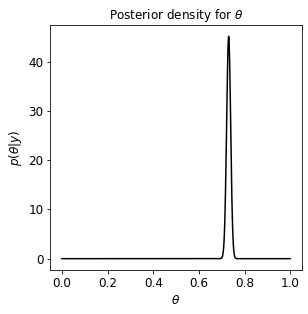

In [47]:
#posterior density given point estimated prior
y = observs[-1,0]
n = observs[-1,1]
alpha_post = alpha+y
beta_post = beta+n-y
#print(beta)
print('\nEstimates for the parameters of the posterior density')
print('alpha=%(a).5f,\tbeta=%(b).5f' % {'a':alpha_post,'b':beta_post})
E_theta_post = alpha_post/(alpha_post+beta_post)
D_theta_post = alpha_post*beta_post/\
    ((alpha_post+beta_post)**2*(alpha_post+beta_post+1))
print('Parameters of te posterior density')
print('E(theta)=%(e).5f,\tstD(theta)=%(v).5f' % \
    {'e':E_theta_post, 'v':np.sqrt(D_theta_post)})
theta = np.arange(0,1,0.001)
p = stats.beta.pdf(theta,alpha_post, beta_post)

fig = plt.figure(figsize=[4.5,4.5])
ax = fig.add_subplot(111)
ax.plot(theta,p,'k-')
ax.set_xlabel(r'$\theta$',fontsize=12)
ax.set_ylabel(r'$p(\theta|y)$',fontsize=12)
ax.set_title(r'Posterior density for $\theta$',fontsize=12)
# fig.show()

In [48]:
print(alpha,beta,np.log(alpha/beta),np.log(alpha+beta))

1511.7845809494759 572.4238662032186 0.9711663318849737 7.642144420497381


### now establish the Bayesian model and obtain the posterior distribution $p(\alpha,\beta)$ in a regular grid of $\alpha$ and $\beta$.

It is found that the distribution is highly skewed to small $\alpha$ and $beta$. The significant asymmetry leads to large uncertainties in determine the best $\alpha$ and $\beta$.

Text(0.5, 0, '$\\beta$')

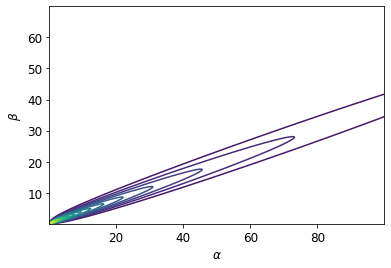

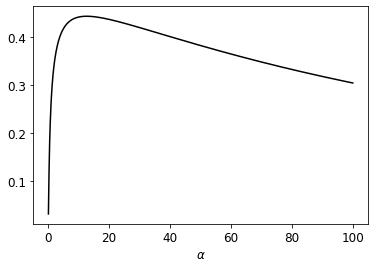

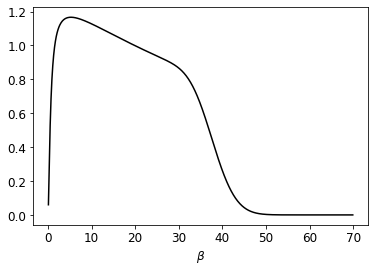

In [49]:
#Bayesian model
def posteriorln(x,y,n):
    '''
    posterior density in log scale
    '''
    alpha = x[0]
    beta = x[1]
    lnlikeli = 0.
    for j in range(len(y)):
        lnlikeli += special.gammaln(alpha+beta)+\
            special.gammaln(alpha+y[j])+\
            special.gammaln(beta+n[j]-y[j])-\
            special.gammaln(alpha)-special.gammaln(beta)-\
            special.gammaln(alpha+beta+n[j])
    priorln = -5./2.*np.log(alpha+beta) #non-information prior
    return lnlikeli+priorln+1010.#rescaled so that the returned value is within the validate range of float number

def draw_posterior(y,n,alphagrid,betagrid):
    '''
    Calculate posterior density at a fixed 2D grid of parameters
    '''
    p = np.zeros((len(alphagrid),len(betagrid)))
    for i in range(len(alphagrid)):
        for j in range(len(betagrid)):
            p[i,j] = posteriorln([alphagrid[i],betagrid[j]],y,n)
    return p



alphagrid = np.arange(0.1,100,0.1)
betagrid = np.arange(0.1,70,0.1)
p = draw_posterior(observs[:-1,0],observs[:-1,1],\
        alphagrid,betagrid)

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.contour(amesh, bmesh, np.exp(p.T),20,\
            extent=[alphagrid[0],\
            alphagrid[-1],betagrid[0],betagrid[-1]])
ax.set_xlabel(r'$\alpha$',fontsize=12)
ax.set_ylabel(r'$\beta$',fontsize=12)

# fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.plot(alphagrid, np.sum(np.exp(p), axis=1),'k-')
ax.set_xlabel(r'$\alpha$',fontsize=12)

# fig.show()
        
fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(alphagrid,betagrid)
ax.plot(betagrid, np.sum(np.exp(p), axis=0),'k-')
ax.set_xlabel(r'$\beta$',fontsize=12)

# fig.show()

In [30]:
np.max(p)
#np.log(25+14)

-3.402350791918252

### Instead of directing using $\alpha$-$\beta$ grid, we turn to use $a=\ln(\alpha/\beta)$ and $b=\ln(\alpha+\beta)$
in the new ($a$,$b$) grid, the shape of the posterior distribution looks much better

max likeli a=0.970, b=6.930
max likeli alpha=741.430, beta=281.064
3.3362472003214734


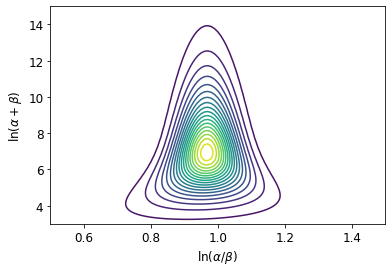

In [50]:
def draw_posteriorln(y,n,agrid,bgrid):
    '''
    Draw posterior density at 2D grid of parameters in log scales
    prior is non-informative
    agrid and bgrid are in log scales
    '''
    p = np.zeros((len(agrid),len(bgrid)))
    for i in range(len(agrid)):
        for j in range(len(bgrid)):
            #convert it back to linear scale and obtain alpha and beta
            alpha = np.exp(agrid[i]+bgrid[j])/(1+np.exp(agrid[i]))
            beta = np.exp(bgrid[j])/(1+np.exp(agrid[i]))
            #print alpha,beta
            Jacob_detln = -np.log(alpha)-np.log(beta)
            #calculate posterior density in log scale
            p[i,j] = posteriorln([alpha,beta],y,n)-Jacob_detln
    return p

agrid = np.arange(0,2,0.01)
bgrid = np.arange(1,20,0.01)
p2 = draw_posteriorln(observs[:-1,0],observs[:-1,1],\
        agrid,bgrid)
#print(p2.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
amesh,bmesh = np.meshgrid(agrid,bgrid)
ii = np.argmax(p2.T)
amesh_f = amesh.flatten()
bmesh_f = bmesh.flatten()
print('max likeli a=%(a).3f, b=%(b).3f' % {'a':amesh_f[ii],'b':bmesh_f[ii]})
alpha = np.exp(amesh_f[ii]+bmesh_f[ii])/(1+np.exp(amesh_f[ii]))
beta = np.exp(bmesh_f[ii])/(1+np.exp(amesh_f[ii]))
print('max likeli alpha=%(a).3f, beta=%(b).3f' % {'a':alpha,'b':beta})
ax.contour(amesh, bmesh, np.exp(p2.T),20,\
            extent=[alphagrid[0],\
            alphagrid[-1],betagrid[0],betagrid[-1]])
ax.set_xlim([0.5,1.5])
ax.set_ylim([3,15])
ax.set_xlabel(r'$\ln(\alpha/\beta)$',fontsize=12)
ax.set_ylabel(r'$\ln(\alpha+\beta)$',fontsize=12)

# fig.show()

print(np.max((p2.T)))

We can randomly draw $a$ and $b$ from this posterior distribution and convert them to $\alpha$ and $\beta$

0.9675478714294841 6.9320009344160205
mean(alpha|y)=681472.09639	mean(beta|y)=261336.21748
mode(alpha|y)=742.41433	mode(beta|y)=282.12764


Text(0.5, 0, '$\\beta$')

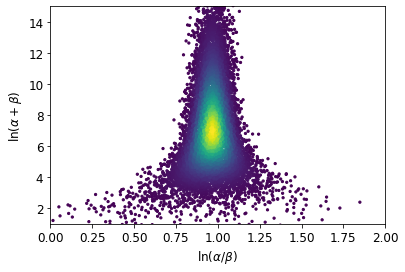

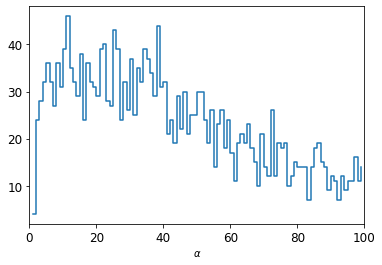

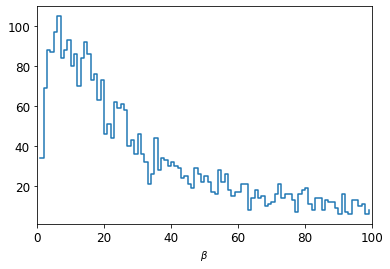

In [53]:
#sample random values from p(ln(a/b),ln(a+b))
N = 100000
a0 = np.random.uniform(0,2,size=N)
b0 = np.random.uniform(0,20,size=N)
p0 = np.random.uniform(0,3.35,size=N)
alpha0 = np.exp(a0+b0)/(1+np.exp(a0))
beta0 = np.exp(b0)/(1+np.exp(a0))
Jacob_detln = -np.log(alpha0)-np.log(beta0)
p = np.exp([posteriorln([alpha0[i],beta0[i]],\
    observs[:-1,0],observs[:-1,1])-Jacob_detln[i] \
    for i in range(N)])
ind = (p0<=p)
a = a0[ind]
b = b0[ind]
alpha = alpha0[ind]
beta = beta0[ind]
pp = p[ind]
ii = np.argmax(pp)
# print(a[ii],b[ii])
print('mean(alpha|y)=%(a).5f\tmean(beta|y)=%(b).5f' %\
    {'a': np.mean(alpha),'b': np.mean(beta)})
print('mode(alpha|y)=%(a).5f\tmode(beta|y)=%(b).5f' %\
    {'a': alpha[ii],'b': beta[ii]})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(a,b,c=pp,s=20,marker='.')
ax.set_xlim([0,2])
ax.set_ylim([1,15])
ax.set_xlabel(r'$\ln(\alpha/\beta)$',fontsize=12)
ax.set_ylabel(r'$\ln(\alpha+\beta)$',fontsize=12)
# fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ha,xedge = np.histogram(alpha,np.arange(0,100,1))
ax.step(xedge[1:],ha,where='post')
ax.set_xlim(0,100)
ax.set_xlabel(r'$\alpha$')
# fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
hb,xedge = np.histogram(beta,np.arange(0,100,1))
ax.step(xedge[1:],hb,where='post')
ax.set_xlim(0,100)
ax.set_xlabel(r'$\beta$')
# fig.show()


We can also predict the expected fraction of stars, in form of distribution in next field.

mean(theta|alpha,beta,y)=0.72638
std(theta|alpha,beta,y)=0.00520


/tmp/ipykernel_26390/669204256.py:8: RuntimeWarning: divide by zero encountered in log
  pln = pln+np.log(stats.beta.pdf(theta,a,b))#use Beta density provided by scipy.stats


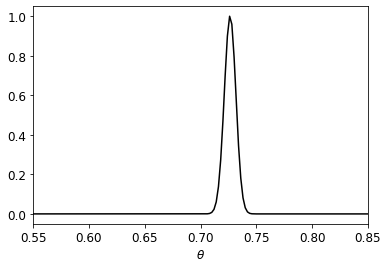

In [38]:
#predict post density of theta 
theta = np.arange(0,1,0.002)
pln = np.zeros(np.shape(theta))
for j in range(J):
    #Conjugate posterior
    a = alpha[ii]+observs[j,0]#a+y
    b = beta[ii]+observs[j,1]-observs[j,0]#b+n-y
    pln = pln+np.log(stats.beta.pdf(theta,a,b))#use Beta density provided by scipy.stats

p = np.exp(pln-np.max(pln))

mean_theta_post = np.sum(p*theta)/np.sum(p)
std_theta_post = np.sqrt(np.sum(p*(theta-\
    mean_theta_post)**2)/np.sum(p))
print('mean(theta|alpha,beta,y)=%(p).5f' %\
    {'p':mean_theta_post})
print('std(theta|alpha,beta,y)=%(p).5f' %\
    {'p':std_theta_post})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta,p,'k-')
ax.set_xlabel(r'$\theta$',fontsize=12)
ax.set_xlim([0.55,0.85])
fig.show()


Now look at the averaged star fraction in the 5 fields to check out whether there is any outlier.

(0.68, 0.78)

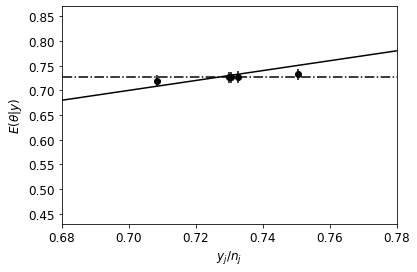

In [41]:

#estimate theta_j from the given mean alpha and beta
p_theta_post = np.zeros((J,2))
for j in range(J):
    a = alpha[ii]+observs[j,0]
    b = beta[ii]+observs[j,1]-observs[j,0]
    p_theta_post[j,0] = a/(a+b)#Mean
    p_theta_post[j,1] =np.sqrt(a*b/((a+b)**2*(a+b+1)))#Var

    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(observs[:,0]/observs[:,1],p_theta_post[:,0],\
    yerr=p_theta_post[:,1],fmt='ko')
ax.plot([0.45,0.85],[0.45,0.85],'-k')
ax.plot([0,1],[mean_theta_post,mean_theta_post],'k-.')
ax.set_xlabel(r'$y_j/n_j$',fontsize=12)
ax.set_ylabel(r'$E(\theta|y)$',fontsize=12)
ax.set_xlim([0.68,0.78])

# fig.show()

Text(0.5, 1.0, 'n=50, theta=0.726')

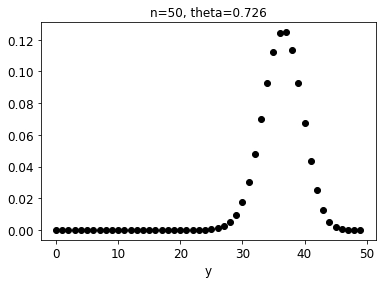

In [42]:
#predict next y from posterior theta
y = np.arange(0,50,1)
p_y = stats.binom.pmf(y,50,mean_theta_post)#Bin density with given best estimated theta

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y,p_y,'ko')
ax.set_xlabel('y',fontsize=12)
ax.set_title('n=50, theta=%(t).3f' % {'t': mean_theta_post})

# fig.show()